In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from data_path import DATA_PATH

In [3]:
os.listdir(
    Path.cwd() / 'egs_cost_data'
)

['egs_costs_s_72_2015.csv',
 'egs_costs_s_72_2020.csv',
 'egs_costs_s_72_2025.csv',
 'egs_costs_s_72_2030.csv',
 'egs_costs_s_72_2035.csv',
 'egs_costs_s_72_2040.csv',
 'egs_costs_s_72_2045.csv',
 'egs_costs_s_72_2050.csv']

In [ ]:
idx = pd.IndexSlice

gt = pd.read_csv(
    DATA_PATH /
    'joint_data' /
    'nodal_geothermal_stats.csv',
    header=[0,1,2,3,4,5,6,7,8],
    index_col=[0,1]
)

gt.columns = gt.columns.droplevel([0,1,2,3,7,8])
gt = gt.loc[:, idx[:, 'elec', 'static']]
gt.columns = gt.columns.get_level_values(0)


gt.index.get_level_values(1).unique()

gt = gt.loc[idx[:, 'geothermal heat elec'], :]
gt.index = gt.index.get_level_values(0)
gt = gt > 1

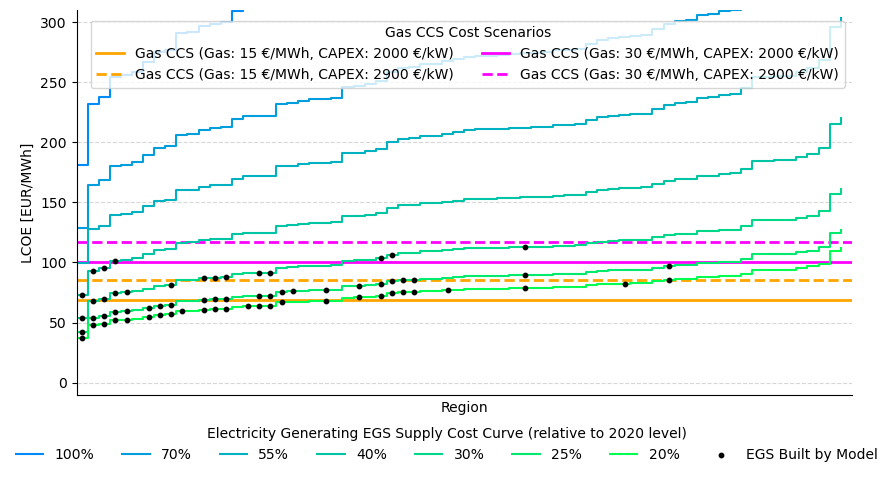

In [92]:
ngcc_ccs_capex_lower = 2_000_000# Euro/MW_elec
ngcc_ccs_capex_higher = 2_900_000

ngcc_ccs_lifetime = 30
ngcc_ccs_efficiency = 0.47

low_gas_price = 15 # EUR/MWh
high_gas_price = 30 # EUR/MWh

ngcc_ccs_capacity_factor = 0.5


fig, ax = plt.subplots(figsize=(10, 5))
    
dr = 0.07

annuity_factor = dr * (1 + dr) ** ngcc_ccs_lifetime / ((1 + dr) ** ngcc_ccs_lifetime - 1)

lowlow = (
    ngcc_ccs_capex_lower * annuity_factor +
    low_gas_price * ngcc_ccs_capacity_factor * 8760 / ngcc_ccs_efficiency
) / 8760 / ngcc_ccs_capacity_factor
ax.axhline(lowlow, color='orange', linestyle='-', label=f'Gas CCS (Gas: {low_gas_price} €/MWh, CAPEX: {int(ngcc_ccs_capex_lower/1000)} €/kW)', lw=2)

lowhigh = (
    ngcc_ccs_capex_higher * annuity_factor +
    low_gas_price * ngcc_ccs_capacity_factor * 8760 / ngcc_ccs_efficiency
) / 8760 / ngcc_ccs_capacity_factor
ax.axhline(lowhigh, color='orange', linestyle='--', label=f'Gas CCS (Gas: {low_gas_price} €/MWh, CAPEX: {int(ngcc_ccs_capex_higher/1000)} €/kW)', lw=2)

highlow = (
    ngcc_ccs_capex_lower * annuity_factor +
    high_gas_price * ngcc_ccs_capacity_factor * 8760 / ngcc_ccs_efficiency
) / 8760 / ngcc_ccs_capacity_factor
ax.axhline(highlow, color='magenta', linestyle='-', label=f'Gas CCS (Gas: {high_gas_price} €/MWh, CAPEX: {int(ngcc_ccs_capex_lower/1000)} €/kW)', lw=2)

highhigh = (
    ngcc_ccs_capex_higher * annuity_factor +
    high_gas_price * ngcc_ccs_capacity_factor * 8760 / ngcc_ccs_efficiency
) / 8760 / ngcc_ccs_capacity_factor
ax.axhline(highhigh, color='magenta', linestyle='--', label=f'Gas CCS (Gas: {high_gas_price} €/MWh, CAPEX: {int(ngcc_ccs_capex_higher/1000)} €/kW)', lw=2)

for year, pct in [(2020, '100%'), (2025, '70%'), (2030, '55%'), (2035, '40%'), 
                  (2040, '30%'), (2045, '25%'), (2050, '20%')]:

    c = pd.read_csv(
        Path.cwd() / 'egs_cost_data' / f'egs_costs_s_72_{year}.csv'
    ).set_index('name').dropna()['capex_mean'].sort_values() * 1000

    gt = gt.loc[c.index]

    lt = 25
    eta = 0.97
    eta_el = 0.12

    orc_cost_th = 1500 * 1000 * eta_el

    annuity_factor = dr * (1 + dr) ** lt / ((1 + dr) ** lt - 1)

    # lcoe = (c * annuity_factor / eta_el + annuity_factor * orc_cost_th) / eta / 8760
    lcoe = (c + eta_el * orc_cost_th) * annuity_factor / (eta * 8760 * eta_el)

    x = np.arange(len(lcoe))

    # Interpolate between #008bfa (start) and #00ff51 (end)
    fraction = (year - 2020) / (2050 - 2020)
    r = int(0x00 + (0x00 - 0x00) * fraction)
    g = int(0x8b + (0xff - 0x8b) * fraction)
    b = int(0xfa + (0x51 - 0xfa) * fraction)
    color = f'#{r:02x}{g:02x}{b:02x}'

    ax.step(x, lcoe.values, where='post', label=pct, color=color)
    
    # Add golden scatter points where gt is True for this year
    mask = gt[str(year)]
    if year == 2050:  # Only add to legend once
        ax.scatter(x[mask] + 0.5, lcoe[mask], color='k', zorder=3, s=10, edgecolors='black', label='EGS Built by Model')
    else:
        ax.scatter(x[mask] + 0.5, lcoe[mask], color='k', zorder=3, s=10, edgecolors='black')
    
    ax.set_xlabel('Region')
    ax.set_ylabel('LCOE [EUR/MWh]')

# Create two separate legends
gas_ccs_legend = ax.legend(
    [l for l in ax.lines if 'Gas CCS' in l.get_label()],
    [l.get_label() for l in ax.lines if 'Gas CCS' in l.get_label()],
    loc='upper right',
    title='Gas CCS Cost Scenarios',
    fontsize=10,
    ncol=2,
    bbox_to_anchor=(1, .99),
    frameon=True
)

# Add the first legend back
ax.add_artist(gas_ccs_legend)

# Create second legend for EGS costs
handles = [l for l in ax.lines if 'Gas CCS' not in l.get_label()]
labels = [l.get_label() for l in ax.lines if 'Gas CCS' not in l.get_label()]

handles.append(plt.scatter([], [], color='k', s=10, edgecolors='black'))
labels.append('EGS Built by Model')

ax.legend(
    handles,
    labels,
    loc='upper right',
    title='Electricity Generating EGS Supply Cost Curve (relative to 2020 level)',
    fontsize=10,
    ncol=8,
    bbox_to_anchor=(1.05, -.05),
    frameon=False
)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([])
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

ax.set_ylim(-10, 310)
ax.set_xlim(0, len(lcoe))

plt.savefig('sensitivity_gas_ccs.pdf', bbox_inches='tight')
plt.show()